In [9]:
import warnings
warnings.filterwarnings("ignore")

import os
import pickle
from scipy.interpolate import interp1d

import numpy as np
#from ler.rates import LeR
import json
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.cosmology import LambdaCDM
cosmoLambdaCDM = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
cosmo = cosmoLambdaCDM

from astropy.cosmology import Planck18

from scipy.integrate import quad, dblquad
from scipy.stats import gengamma, rayleigh
from scipy.special import gamma

from numba import njit, jit
from ler.utils import rejection_sample
from scipy.interpolate import interp1d

In [ ]:
# import gamma function


In [13]:
from ler.lens_galaxy_population import LensGalaxyPopulation

lens = LensGalaxyPopulation(z_max=40, cosmology=cosmoLambdaCDM,) 

ImportError: cannot import name 'create_inv_cdf' from 'ler.utils' (/Users/phurailatpamhemantakumar/phd/mypackages/ler/ler/utils/__init__.py)

In [3]:
import test
#reload(test)
import importlib
importlib.reload(test)

<module 'test' from '/Users/phurailatpamhemantakumar/phd/mypackages/ler/examples/optical_depth/test.py'>

## Difference between $\phi_{loc}^{Bernardi}$ and $\Gamma$ distribution from Haris

In [11]:
size = 10000

# philocbernardi
# normalised pdf
sigma_pdf_SIS2 = lambda sig_: test.philocbernardi(sig_)
sigma_pdf_norm_SIS2 = quad(sigma_pdf_SIS2, 1, 600)[0]
sigma_pdf_SIS2 = lambda sig_: test.philocbernardi(sig_)/sigma_pdf_norm_SIS2

def sample_sigma_SIS2(sigma_lim=[1,600], size=200):
    sigma = rejection_sample(sigma_pdf_SIS2, sigma_lim[0], sigma_lim[1], size=size, chunk_size=1000)
    return sigma

# gen_gamma
# normalised pdf
sigma_pdf_SIS1 = lambda sig_: gengamma.pdf(sig_/161, 2.32 / 2.67, 2.67)
sigma_pdf_norm_SIS1 = quad(sigma_pdf_SIS1, 1, 600)[0]
sigma_pdf_SIS1 = lambda sig_: gengamma.pdf(sig_/161, 2.32 / 2.67, 2.67)/sigma_pdf_norm_SIS1

def sample_sigma_SIS1(sigma_lim=[1,600], size=200):
    sigma = rejection_sample(sigma_pdf_SIS1, sigma_lim[0], sigma_lim[1], size=size, chunk_size=1000)
    return sigma


# gamma distribition
def gammafunction(sig, alpha=2.32, beta=2.67, sigstar=161.):
    return (sig/sigstar)**(alpha)*np.exp(-(sig/sigstar)**beta)*(beta/gamma(alpha/beta))/sig

sigma_pdf_SIS3 = lambda sig_: gammafunction(sig_)
sigma_pdf_norm_SIS3 = quad(sigma_pdf_SIS3, 1, 600)[0]
sigma_pdf_SIS3 = lambda sig_: gammafunction(sig_)/sigma_pdf_norm_SIS3

def sample_sigma_SIS3(sigma_lim=[1,600], size=200):
    sigma = rejection_sample(sigma_pdf_SIS3, sigma_lim[0], sigma_lim[1], size=size, chunk_size=1000)
    return sigma

sample1 = sample_sigma_SIS2(size=size)
#sample2 = gengamma.rvs(a=2.32 / 2.67, c=2.67, size=size)*161.
sample2 = sample_sigma_SIS1(size=size)
sample3 = sample_sigma_SIS3(size=size)

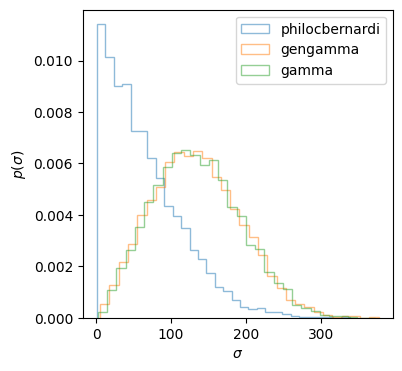

In [12]:
# plot hist
plt.figure(figsize=(4, 4))
plt.hist(sample1, bins=30, density=True, label='philocbernardi', alpha=0.5, histtype='step')
plt.hist(sample2, bins=30, density=True, label='gengamma', alpha=0.5, histtype='step')
plt.hist(sample3, bins=30, density=True, label='gamma', alpha=0.5, histtype='step')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$p(\sigma)$')
plt.legend()
plt.show()


* this quite different 
* higher sigma will lead to higher optical depth

In [6]:
@jit
def cross_section_SIS(sigma, zl, zs):
    Ds = cosmo.angular_diameter_distance(zs)
    Dls = cosmo.angular_diameter_distance_z1z2(zl, zs)
    theta_E = (
        4.0 * np.pi * (sigma / 299792.458) ** 2 * Dls / (Ds)
    )  # Note: km/s for sigma; Dls, Ds are in Mpc
    phi = np.pi * theta_E**2

    return phi

@njit
def phi_cut_SIE(q):
    n = len(q)
    result = np.empty(n)
    for i in range(n):
        val = q[i]
        if 0.01 < val < 0.99:
            result[i] = (2 * np.pi * val * np.log(val)) / (val ** 2 - 1)
        elif val < 0.01:
            result[i] = -2 * (np.pi * np.log(val)) * val
        else:
            result[i] = np.pi
    return result/np.pi

## 0. SIE

* $\sigma_v$ not dependent on z
* normalization of $\sigma_v$ in the range $[0,600]$
* Oguri style

In [7]:
sigma_pdf_SIE0 = lambda sig_: test.philocbernardi(sig_)
sigma_pdf_norm_SIE0 = quad(sigma_pdf_SIE0, 1, 600)[0]
sigma_pdf_SIE0 = lambda sig_: test.philocbernardi(sig_)/sigma_pdf_norm_SIE0

def sample_sigma_q_SIE0(sigma_lim=[1,600], size=200):

    # Draw the velocity dispersion
    # a = gengamma.rvs(2.32 / 2.67, 2.67, size=size)
    # sigma = 161.0 * a
    
    sigma = rejection_sample(sigma_pdf_SIE0, sigma_lim[0], sigma_lim[1], size=size, chunk_size=1000)
    a = sigma/161.0
    q = np.ones(size)
    idx = np.arange(size)  # idx tracker
    size_ = size

    while size_ != 0:
        # Draw the axis ratio see Appendix of https://arxiv.org/pdf/1807.07062.pdf
        s = 0.38 - 0.09177 * a[idx]
        b = rayleigh.rvs(scale=s, size=size_)
        q_ = 1.0 - b

        # Weed out sigmas and axis ratios that have axis ratio below 0.2
        idx2 = q_ > 0.2
        q[idx[idx2]] = q_[idx2]

        # remaining idx from the original array
        # that still not have axis ratio above 0.2
        idx = idx[q < 0.2]
        size_ = len(idx)

    # Transform to an array
    return sigma, q


def integrand_SIE0(zl, zs):
    sigma, q = sample_sigma_q_SIE0(size=200)
    h = lens.cosmo.H(0).value/100
    phi_cut = phi_cut_SIE(q)
    no = 8*1e-3* h**3
    test = (phi_cut)*cross_section_SIS(sigma, zl, zs)/(4*np.pi)*no*lens.differential_comoving_volume(zl)
    # average 
    return np.mean(test)


def optical_depth_SIE0(zs):
    result = quad(integrand_SIE0, 0, zs, args=(zs))

    return result[0]

In [8]:
optical_depth_SIE0(1.5)

NameError: name 'lens' is not defined

## 1. SIE

* $\sigma_v$ not dependent on z
* normalization of $\sigma_v$ in the range $[60,600]$
* Oguri style

In [12]:

sigma_pdf_SIE1 = lambda sig_: test.philocbernardi(sig_)
sigma_pdf_norm_SIE1 = quad(sigma_pdf_SIE1, 60, 600)[0]
sigma_pdf_SIE1 = lambda sig_: test.philocbernardi(sig_)/sigma_pdf_norm_SIE1

def sample_sigma_q_SIE1(sigma_lim=[60,600], size=200):

    # Draw the velocity dispersion
    # a = gengamma.rvs(2.32 / 2.67, 2.67, size=size)
    # sigma = 161.0 * a
    
    sigma = rejection_sample(sigma_pdf_SIE1, sigma_lim[0], sigma_lim[1], size=size, chunk_size=1000)
    a = sigma/161.0
    q = np.ones(size)
    idx = np.arange(size)  # idx tracker
    size_ = size

    while size_ != 0:
        # Draw the axis ratio see Appendix of https://arxiv.org/pdf/1807.07062.pdf
        s = 0.38 - 0.09177 * a[idx]
        b = rayleigh.rvs(scale=s, size=size_)
        q_ = 1.0 - b

        # Weed out sigmas and axis ratios that have axis ratio below 0.2
        idx2 = q_ > 0.2
        q[idx[idx2]] = q_[idx2]

        # remaining idx from the original array
        # that still not have axis ratio above 0.2
        idx = idx[q < 0.2]
        size_ = len(idx)

    # Transform to an array
    return sigma, q


def integrand_SIE1(zl, zs):
    sigma, q = sample_sigma_q_SIE1(size=200)
    h = lens.cosmo.H(0).value/100
    phi_cut = phi_cut_SIE(q)
    no = 8*1e-3* h**3
    test = (phi_cut)*cross_section_SIS(sigma, zl, zs)/(4*np.pi)*no*lens.differential_comoving_volume(zl)
    # average 
    return np.mean(test)


def optical_depth_SIE1(zs):
    result = quad(integrand_SIE1, 0, zs, args=(zs))

    return result[0]

## 2. SIE

* $\sigma_v$ dependent on z
* normalization of $\sigma_v$ in the range $[60,600]$
* normalization of $z$ in the range $[0,3]$
* Oguri style

In [13]:
sigma_pdf_SIE2 = lambda sig_,zl_: test.phi(sig_,zl_)
sigma_pdf_norm_SIE2 = dblquad(sigma_pdf_SIE2, 0, 3, 60, 600)[0]
sigma_pdf_SIE2 = lambda sig_,zl_: test.phi(sig_,zl_)/sigma_pdf_norm_SIE2

def sample_sigma_q_SIE2(zl, sigma_lim=[60,600], size=200):

    sigma = test.conditional_rejection_sample(sigma_pdf_SIE2,sigma_lim[0],sigma_lim[1],zl,size=size,chunk_size=1000)
    
    a = sigma/161.0
    q = np.ones(size)
    idx = np.arange(size)  # idx tracker
    size_ = size

    while size_ != 0:
        # Draw the axis ratio see Appendix of https://arxiv.org/pdf/1807.07062.pdf
        s = 0.38 - 0.09177 * a[idx]
        b = rayleigh.rvs(scale=s, size=size_)
        q_ = 1.0 - b

        # Weed out sigmas and axis ratios that have axis ratio below 0.2
        idx2 = q_ > 0.2
        q[idx[idx2]] = q_[idx2]

        # remaining idx from the original array
        # that still not have axis ratio above 0.2
        idx = idx[q < 0.2]
        size_ = len(idx)

    # Transform to an array
    return sigma, q

def integrand_SIE2(zl, zs):
    sigma, q = sample_sigma_q_SIE2(zl,size=200)
    h = lens.cosmo.H(0).value/100
    phi_cut = phi_cut_SIE(q)
    no = 8*1e-3* h**3
    test = (phi_cut)*cross_section_SIS(sigma, zl, zs)/(4*np.pi)*no*lens.differential_comoving_volume(zl)
    # average 
    return np.mean(test)

def optical_depth_SIE2(zs):
    result = quad(integrand_SIE2, 0, zs, args=(zs))

    return result[0]

## 3. SIS

* $\sigma_v$ independent on z
* normalization of $\sigma_v$ in the range $[60,600]$
* Haris style

In [14]:
# normalised pdf
sigma_pdf_SIS1 = lambda sig_: gengamma.pdf(sig_/161, 2.32 / 2.67, 2.67)
sigma_pdf_norm_SIS1 = quad(sigma_pdf_SIS1, 60, 600)[0]
sigma_pdf_SIS1 = lambda sig_: gengamma.pdf(sig_/161, 2.32 / 2.67, 2.67)/sigma_pdf_norm_SIS1

def sample_sigma_SIS1(sigma_lim=[60,600], size=200):

    sigma = rejection_sample(sigma_pdf_SIS1, sigma_lim[0], sigma_lim[1], size=size, chunk_size=1000)

    return sigma

def integrand_SIS1(zl, zs):
    sigma = sample_sigma_SIS1(size=200)
    # def sigma():
    #     a = gengamma.rvs(2.32 / 2.67, 2.67, size=1)
    #     sigma_ = 161.0 * a
    #     return sigma_
    # sigma = sigma()
    
    h = lens.cosmo.H(0).value/100
    no = 8*1e-3* h**3
    test = cross_section_SIS(sigma, zl, zs)/(4*np.pi)*no*lens.differential_comoving_volume(zl)
    # average 
    return np.mean(test)

def optical_depth_SIS1(zs):
    result = quad(integrand_SIS1, 0, zs, args=(zs))

    return result[0]

In [15]:
optical_depth_SIS1(1.5)

0.0003908674094551756

In [25]:
# normalised pdf
sigma_pdf_SIS3 = lambda sig_: gengamma.pdf(sig_/161, 2.32 / 2.67, 2.67)
sigma_pdf_norm_SIS3 = quad(sigma_pdf_SIS3, 0, 600)[0]
sigma_pdf_SIS3 = lambda sig_: gengamma.pdf(sig_/161, 2.32 / 2.67, 2.67)/sigma_pdf_norm_SIS3

def sample_sigma_SIS3(sigma_lim=[0,600], size=200):

    sigma = rejection_sample(sigma_pdf_SIS3, sigma_lim[0], sigma_lim[1], size=size, chunk_size=1000)

    return sigma

def integrand_SIS3(zl, zs):
    sigma = sample_sigma_SIS3(size=200)
    # def sigma():
    #     a = gengamma.rvs(2.32 / 2.67, 2.67, size=1)
    #     sigma_ = 161.0 * a
    #     return sigma_
    # sigma = sigma()
    
    h = lens.cosmo.H(0).value/100
    no = 8*1e-3* h**3
    test = cross_section_SIS(sigma, zl, zs)/(4*np.pi)*no*lens.differential_comoving_volume(zl)
    # average 
    return np.mean(test)

def optical_depth_SIS3(zs):
    result = quad(integrand_SIS3, 0, zs, args=(zs))

    return result[0]

In [26]:
optical_depth_SIS3(1.5)

0.00034886195593006856

In [18]:
# normalised pdf
sigma_pdf_SIS2 = lambda sig_: test.philocbernardi(sig_)
sigma_pdf_norm_SIS2 = quad(sigma_pdf_SIS2, 60, 600)[0]
sigma_pdf_SIS2 = lambda sig_: test.philocbernardi(sig_)/sigma_pdf_norm_SIS2

def sample_sigma_SIS2(sigma_lim=[60,600], size=200):

    sigma = rejection_sample(sigma_pdf_SIS2, sigma_lim[0], sigma_lim[1], size=size, chunk_size=1000)

    return sigma

def integrand_SIS2(zl, zs):
    sigma = sample_sigma_SIS2(size=200)
    # def sigma():
    #     a = gengamma.rvs(2.32 / 2.67, 2.67, size=1)
    #     sigma_ = 161.0 * a
    #     return sigma_
    # sigma = sigma()
    
    h = lens.cosmo.H(0).value/100
    no = 8*1e-3* h**3
    test = cross_section_SIS(sigma, zl, zs)/(4*np.pi)*no*lens.differential_comoving_volume(zl)
    # average 
    return np.mean(test)

def optical_depth_SIS2(zs):
    result = quad(integrand_SIS2, 0, zs, args=(zs))

    return result[0]

In [19]:
optical_depth_SIS2(1.5)

0.000984251990571789

In [20]:
def strong_lensing_optical_depth_SIS(zs):
    # For SIS model
    # z to luminosity_distance (luminosity_distance) conversion
    Dc = cosmo.comoving_distance(zs).value * 1e-3  # 1e-3 converts Mpc to Gpc

    return 4.17*1e-6*(Dc) ** 3

strong_lensing_optical_depth_SIS(zs=1.5)

0.0003465350907932671

* normalization matters

### Velcity dispersion comparision

In [26]:
sigma1, q1 = sample_sigma_q_SIE1(size=1000)

In [27]:
sigma2, q2 = sample_sigma_q_SIE2(zl=1, size=1000)

In [30]:
sigma3 = sample_sigma_SIS1(sigma_lim=[60,600], size=200)

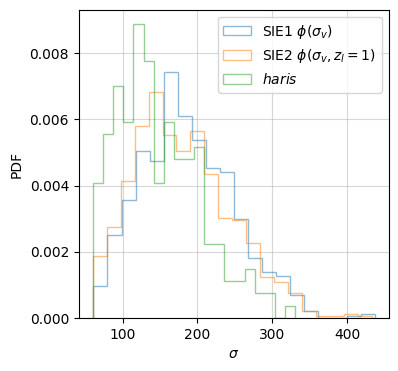

In [31]:
# all three models are normalised, sigma->[60,600]
# plot comparison
plt.figure(figsize=(4,4))
plt.hist(sigma1, bins=20, alpha=0.5, label=r'SIE1 $\phi(\sigma_v)$', density=True, histtype='step')
plt.hist(sigma2, bins=20, alpha=0.5, label=r'SIE2 $\phi(\sigma_v,z_l=1)$', density=True, histtype='step')
plt.hist(sigma3, bins=20, alpha=0.5, label=r'$haris$', density=True, histtype='step')
plt.xlabel(r'$\sigma$')
plt.ylabel('PDF')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

* gamma distribution taken by Haris is different as compare to Oguri

### Optical depth comparision

In [21]:
zs = np.linspace(0.001, 2, 10)
tau_sie1 = np.array([optical_depth_SIE1(zs=z) for z in zs])

In [22]:
# takes 2m 58s for 10 zs
zs = np.linspace(0.001, 2, 10)
tau_sie2 = np.array([optical_depth_SIE2(zs=z) for z in zs])

In [23]:
zs = np.linspace(0.001, 2, 10)
tau_sis1 = np.array([optical_depth_SIS1(zs=z) for z in zs])


In [24]:
zs = np.linspace(0.001, 2, 10)
tau_sis2 = np.array([optical_depth_SIS2(zs=z) for z in zs])

In [27]:
zs = np.linspace(0.001, 2, 10)
tau_sis3 = np.array([optical_depth_SIS3(zs=z) for z in zs])

In [28]:
zs = np.linspace(0.001, 2, 10)
tau_haris = strong_lensing_optical_depth_SIS(zs)

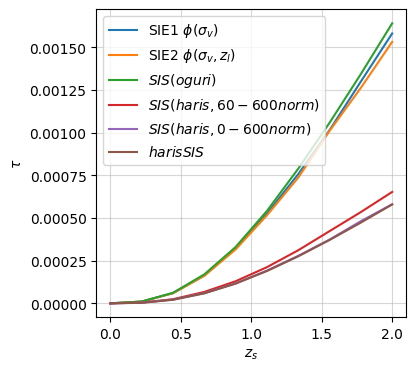

In [31]:
# plot
plt.figure(figsize=(4,4))
plt.plot(zs, tau_sie1, label=r'SIE1 $\phi(\sigma_v)$')
plt.plot(zs, tau_sie2, label=r'SIE2 $\phi(\sigma_v,z_l)$')
plt.plot(zs, tau_sis2, label=r'$SIS (oguri)$')
plt.plot(zs, tau_sis1, label=r'$SIS (haris, 60-600norm)$')
plt.plot(zs, tau_sis3, label=r'$SIS (haris, 0-600norm)$')
plt.plot(zs, tau_haris, label=r'$haris SIS$')
plt.xlabel(r'$z_s$')
plt.ylabel(r'$\tau$')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

### Conclusion

| Model | Lens Model | $\sigma_v$ Dependency on $z$ | Normalization of $\sigma_v$ | Normalization of $z$ | Sigma Cut Dependency | Gamma Distribution Source |
|-------|------------|-------------------------------|-----------------------------|----------------------|----------------------|---------------------------|
| 1     | SIE        | No                           | [60, 600]                   | None                 | Mass Ratio           | Oguri                    |
| 2     | SIE        | Yes                          | [60, 600]                   | [0, 3]               | Mass Ratio           | Oguri                    |
| 3     | SIS        | No                           | [60, 600]                   | None               | Mass Ratio           | Oguri                    |
| 4     | SIS        | No                           | [60, 600]                   | None                 | None                 | Haris                    |
| 4     | SIS        | No                           | [0, 600]                   | None                 | None                 | Haris                    |
| 5     | SIS        | No                           | None                        | None                 | None                 | Haris                    |



* The difference mainly comes from the velocity dispersion distribution shape and also the normalization
* The difference between the model1/2/3 is not very large.
* Between model4 and model5/model6, the difference is significant, which means the normalization range of velocity dispersion is important.
* model 5 and model 6 are the same, which means the normalization of redshift is not important if the range is the the same. This also proves that haris model underestimates the velocity dispersion and hence the optical depth.

## Check for $z_l$ distribution  

* fixed $\sigma_v=161 km/s$ 

In [224]:
# use interpolation to find the pdf of zl
def zl_pdf_SIE(zl_list, zs=5, sigma=161):
    sigma_pdf_SIE2 = lambda sig_,zl_: test.phi(sig_,zl_)
    zl = np.linspace(0.001, zs, 100)
    sigma = np.ones(len(zl))*sigma
    zl_pdf_unnorm = interp1d(zl, sigma_pdf_SIE2(sigma,zl), kind='cubic')
    zl_norm = quad(zl_pdf_unnorm, 0.001, zs)[0]

    return zl_pdf_unnorm(zl_list)/zl_norm

In [220]:
zl_lens = lens.sample_lens_redshifts(np.ones(1000)*2)

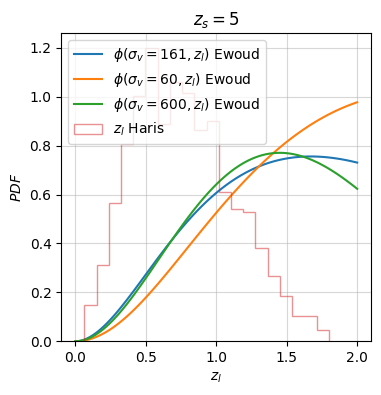

In [227]:
# plot
zl = np.linspace(0.001, 2, 100)
plt.figure(figsize=(4,4))
plt.plot(zl, zl_pdf_SIE(zl, zs=2, sigma=161), label=r'$\phi(\sigma_v=161,z_l)$ Ewoud')
plt.plot(zl, zl_pdf_SIE(zl, zs=2, sigma=60), label=r'$\phi(\sigma_v=60,z_l)$ Ewoud')
plt.plot(zl, zl_pdf_SIE(zl, zs=2, sigma=600), label=r'$\phi(\sigma_v=600,z_l)$ Ewoud')
plt.hist(zl_lens, bins=20, alpha=0.5, label=r'$z_l$ Haris', density=True, histtype='step')
plt.title(r'$z_s=5$')
plt.xlabel(r'$z_l$')
plt.ylabel(r'$PDF$')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

* Haris and Oguri style is different

## Validation of the interpolation method of sigma sampling

In [2]:
import test2
#reload(test)
import importlib
importlib.reload(test2)

<module 'test2' from '/Users/phurailatpamhemantakumar/phd/mypackages/ler/examples/optical_depth/test2.py'>

In [3]:
vd = test2.VelocityDispersionSampler()

Inveverse CDF of Velocity dispersion for inverse transform sampling will be loaded from ./interpolator_pickle/vel_disp/inv_cdf_0.pickle


In [ ]:
plt.plot(zs, tau_sie2, label=r'SIE2 $\phi(\sigma_v,z_l)$')

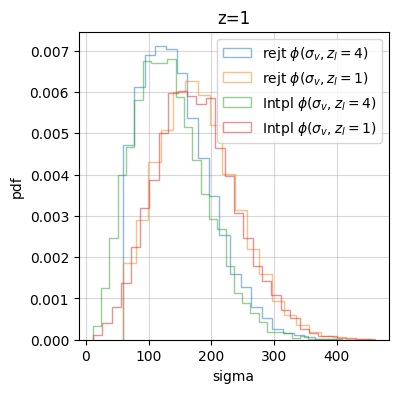

In [45]:
# plot velo disp
plt.figure(figsize=(4,4))

sigma2, q2 = sample_sigma_q_SIE2(zl=4, size=10000)
plt.hist(sigma2, bins=20, alpha=0.5, label=r'rejt $\phi(\sigma_v,z_l=4)$', density=True, histtype='step')
sigma2, q2 = sample_sigma_q_SIE2(zl=1, size=10000)
plt.hist(sigma2, bins=20, alpha=0.5, label=r'rejt $\phi(\sigma_v,z_l=1)$', density=True, histtype='step')

sample = vd.sample_vel_disp(4, 10000)
plt.hist(sample, bins=30, alpha=0.5, density=True, histtype='step', label=r'Intpl $\phi(\sigma_v,z_l=4)$')
sample = vd.sample_vel_disp(1.0, 10000)
plt.hist(sample, bins=30, alpha=0.5, density=True, histtype='step', label=r'Intpl $\phi(\sigma_v,z_l=1)$')

plt.xlabel('sigma')
plt.ylabel('pdf')
plt.title('z=1')
plt.grid(alpha=0.5)
plt.legend()
plt.show()

* It's perfect 

In [1]:
# plot optical depth with zl pdf

def optical_depth_SIS(self, zs):
    """
    Function to compute the strong lensing optical depth (SIS)

    Parameters
    ----------
        zs : `float`
            source redshifts

    Returns
    -------
        tau : `float`
            strong lensing optical depth

    """
    # For SIS model
    # z to luminosity_distance (luminosity_distance) conversion
    Dc = lens.z_to_Dc(zs) * 1e-3  # 1e-3 converts Mpc to Gpc

    return (Dc / 62.2) ** 3

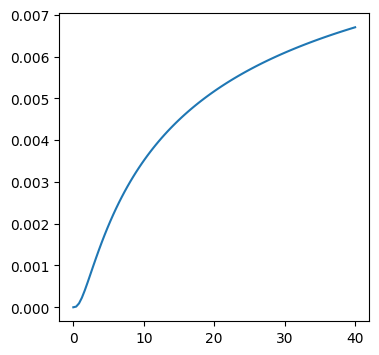

In [6]:
# plot optical depth with zl pdf (sis only)
plt.figure(figsize=(4,4))
zs = np.linspace(0.001, 40, 100)
tau = strong_lensing_optical_depth_SIS(zs)
plt.plot(zs, tau, label=r'$\tau$ SIS')
plt.show()


In [ ]:

        if lens_type == "epl_galaxy":
            sampler_priors_ = dict(
                source_parameters="sample_strongly_lensed_source_parameters",
                lens_redshift="lens_redshift_SDSS_catalogue",
                velocity_dispersion="velocity_dispersion_gengamma",
                axis_ratio="axis_ratio_rayleigh",
                axis_rotation_angle="axis_rotation_angle_uniform",
                shear="shear_norm",
                mass_density_spectral_index="mass_density_spectral_index_normal",
            )
            sampler_priors_params_ = dict(
                source_parameters=None,
                lens_redshift=dict(zs=self.lens_parameters["zs"]),
                velocity_dispersion=dict(a=2.32 / 2.67, c=2.67),
                axis_ratio=dict(sigma=self.lens_parameters["sigma"]),
                axis_rotation_angle=dict(phi_min=0.0, phi_max=2 * np.pi),
                shear=dict(scale=0.05),
                mass_density_spectral_index=dict(mean=2.0, std=0.2),
            )
        else:
            raise ValueError("lens_type not recognized")
        
        # update the priors if input is given
        if sampler_priors:
            sampler_priors_.update(sampler_priors)
        if sampler_priors_params:
            sampler_priors_params_.update(sampler_priors_params)

        # dict of sampler names with description
        lens_sampler_names_ = dict(
            sample_source_parameters="source parameters conditioned on the source being strongly lensed",
            sample_lens_redshift="lens redshift",
            sample_velocity_dispersion="velocity dispersion of elliptical galaxy",
            sample_axis_ratio="axis ratio of elliptical galaxy",
            sample_axis_rotation_angle="axis rotation angle of elliptical galaxy    ",
            sample_shear="shear of elliptical galaxy",
            sample_mass_density_spectral_index="mass density spectral index of elliptical power-law galaxy",
        )

In [1]:
from ler.lens_galaxy_population import LensGalaxyPopulation

lens = LensGalaxyPopulation()

In [2]:
lens.sample_source_redshift_sl(size=10)

array([2.76702821, 6.43989511, 8.3599859 , 1.47381175, 1.58238155,
       3.90471544, 5.03577095, 4.45137479, 3.79623267, 5.2530226 ])

In [3]:
lens.lens_param_samplers_params

{'source_redshift_sl': None,
 'lens_redshift': None,
 'velocity_dispersion': {'a': 0.8689138576779026, 'c': 2.67},
 'axis_ratio': {'q_min': 0.2},
 'axis_rotation_angle': {'phi_min': 0.0, 'phi_max': 6.283185307179586},
 'shear': {'scale': 0.05},
 'mass_density_spectral_index': {'mean': 2.0, 'std': 0.2},
 'source_parameters': None}

In [4]:
# initializing samplers
# self.sample_source_redshift_sl = self.lens_param_samplers["source_redshift_sl"]
# self.sample_lens_redshift = self.lens_param_samplers["lens_redshift"]
# self.sample_velocity_dispersion = self.lens_param_samplers[
#     "velocity_dispersion"
# ]
# self.sample_axis_ratio = self.lens_param_samplers["axis_ratio"]
# self.sample_axis_rotation_angle = self.lens_param_samplers[
#     "axis_rotation_angle"
# ]
# self.sample_shear = self.lens_param_samplers["shear"]
# self.sample_mass_density_spectral_index = self.lens_param_samplers[
#     "mass_density_spectral_index"
# ]
# self.sample_source_parameters = self.lens_param_samplers["source_parameters"]

In [2]:
test = lens.sample_all_routine1(size=1000)

current sampled size 33
current sampled size 77
current sampled size 114
current sampled size 158
current sampled size 182
current sampled size 230
current sampled size 278
current sampled size 303
current sampled size 350
current sampled size 401
current sampled size 426
current sampled size 444
current sampled size 498
current sampled size 533
current sampled size 577
current sampled size 616
current sampled size 659
current sampled size 682
current sampled size 721
current sampled size 769
current sampled size 793
current sampled size 832
current sampled size 862
current sampled size 919
current sampled size 960
current sampled size 982


In [3]:
test.keys()

dict_keys(['zl', 'zs', 'sigma', 'q', 'theta_E', 'phi', 'e1', 'e2', 'gamma1', 'gamma2', 'gamma', 'geocent_time', 'phase', 'psi', 'theta_jn', 'luminosity_distance', 'mass_1_source', 'mass_2_source', 'ra', 'dec'])

In [7]:
from ler.gw_source_population import SourceGalaxyPopulationModel

cbc = SourceGalaxyPopulationModel()

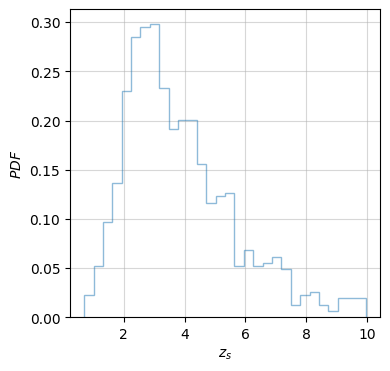

In [4]:
import matplotlib.pyplot as plt

zs = test["zs"]
# plot hist
plt.figure(figsize=(4,4))
plt.hist(zs, bins=30, alpha=0.5, density=True, histtype='step')
plt.xlabel(r'$z_s$')
plt.ylabel(r'$PDF$')
plt.grid(alpha=0.5)
plt.show()

In [78]:
from astropy.cosmology import LambdaCDM
from astropy.cosmology import Planck18

In [79]:
# cosmoLambdaCDM = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
# cosmo = cosmoLambdaCDM
Planck18.comoving_distance(1.2)

<Quantity 3864.91527421 Mpc>

In [80]:
# change planck18 init values
planck = Planck18(H0=60)

TypeError: 'FlatLambdaCDM' object is not callable

In [ ]:
def interpolator_pickle_path(self,
        param_dict_given=dict(
            z_min=0.001,
            z_max=10.,
            vd_min=60,
            vd_max=600,
            cosmology=cosmo,),
        directory="./interpolator_pickle",
        sub_directory = "velocity_dispersion_bernardi",
        ):
        """
        Function to create the interpolator pickle file path for velocity dispersion.
        """
        
        # check the dir 'interpolator' exist
        full_dir = directory + "/" + sub_directory
        if not os.path.exists(directory):
            os.makedirs(directory)
            os.makedirs(full_dir)
        else:
            if not os.path.exists(full_dir):
                os.makedirs(full_dir)

        # check if param_dict_list.pickle exists
        path1 = full_dir + "/init_dict.pickle"
        if not os.path.exists(path1):
            dict_list = []
            with open(path1, "wb") as handle:
                pickle.dump(dict_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

        # check if the input dict is the same as one of the dict inside the pickle file
        param_dict_stored = pickle.load(open(path1, "rb"))
        
        path2 = full_dir
        len_ = len(param_dict_stored)
        if param_dict_given in param_dict_stored:
            idx = param_dict_stored.index(param_dict_given)
            # load the interpolator
            path_inv_cdf = path2 + "/inv_cdf_" + str(idx) + ".pickle"
            # there will be exception if the file is deleted by mistake
            if os.path.exists(path_inv_cdf):
                it_exist = True
            else:
                it_exist = False
        else:
            it_exist = False
            path_inv_cdf = path2 + "/inv_cdf_" + str(len_) + ".pickle"
            param_dict_stored.append(param_dict_given)
            with open(path1, "wb") as handle:
                pickle.dump(param_dict_stored, handle, protocol=pickle.HIGHEST_PROTOCOL)

        return path_inv_cdf, it_exist

In [9]:

def create_pdf_cdf_invcdf(x,y, type="all"):
    
    # remove idx of nan values
    idx = np.argwhere(np.isnan(y))
    x = np.delete(x, idx)
    y = np.delete(y, idx)
    # create pdf with interpolation
    pdf_unorm = interp1d(x, y, kind='cubic', fill_value="extrapolate")
    xlim=[x[0], x[-1]]
    norm = quad(pdf_unorm, xlim[0], xlim[1])[0]
    y = y/norm 
    # normalize the pdf
    pdf = interp1d(x, y, kind='cubic', fill_value="extrapolate")
    if type=="pdf":
        return  pdf
    # create cdf
    cdf = lambda x: quad(pdf, xlim[0], x)[0]
    # get all values of cdf
    cdf_values = np.array([cdf(x_) for x_ in x])
    cdf = interp1d(x, cdf_values, kind='cubic', fill_value="extrapolate")
    if type=="cdf":
        return cdf
    # create inverse cdf
    inv_cdf = interp1d(cdf_values, x, kind='cubic', fill_value="extrapolate")
    if type=="inv_cdf":
        return inv_cdf
    # if type is not specified, return all
    return pdf, cdf, inv_cdf

In [11]:
create_pdf_cdf_invcdf(np.array([1,2,3,4]),np.array([1,2,3,4]), type="all")

test
test


(<scipy.interpolate._interpolate.interp1d at 0x107e2bec0>,
 <scipy.interpolate._interpolate.interp1d at 0x137b1b1a0>)